<a href="https://colab.research.google.com/github/Csfifty23/Funavry-Poker-Solution/blob/main/Funavry_Poker_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 5.8 MB/s eta 0:00:00


In [2]:
pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


In [3]:
pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.5 MB/s eta 0:00:00


In [4]:
!pip install onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 7.4 MB/s eta 0:00:00


**Importing All the Required Liberaries**

In [5]:
import torch
import onnxruntime as rt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np


In [6]:
rt.get_device()

'GPU'

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

**Loading the fintuned YOLOv8 model which is finetuned on poker images**

In [8]:
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/fintuned-yolo/best.onnx')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.


In [9]:
frame ="/content/T_29.jpg"
result = model(frame)

Loading /content/drive/MyDrive/fintuned-yolo/best.onnx for ONNX Runtime inference...

image 1/1 /content/T_29.jpg: 640x640 3 player_names, 5 player_positions, 1427.3ms
Speed: 91.6ms preprocess, 1427.3ms inference, 96.8ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
for j in result:
  print(j.boxes.conf)

tensor([0.9734, 0.9425, 0.9341, 0.9307, 0.9082, 0.9026, 0.5983, 0.3234])


In [13]:
from PIL import Image
# Show the results
for r in result:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  #

# **Funtion to read images for detection demonstration purpose**

In [14]:
def read_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

# **Detection result of finetuned model on poker game images**

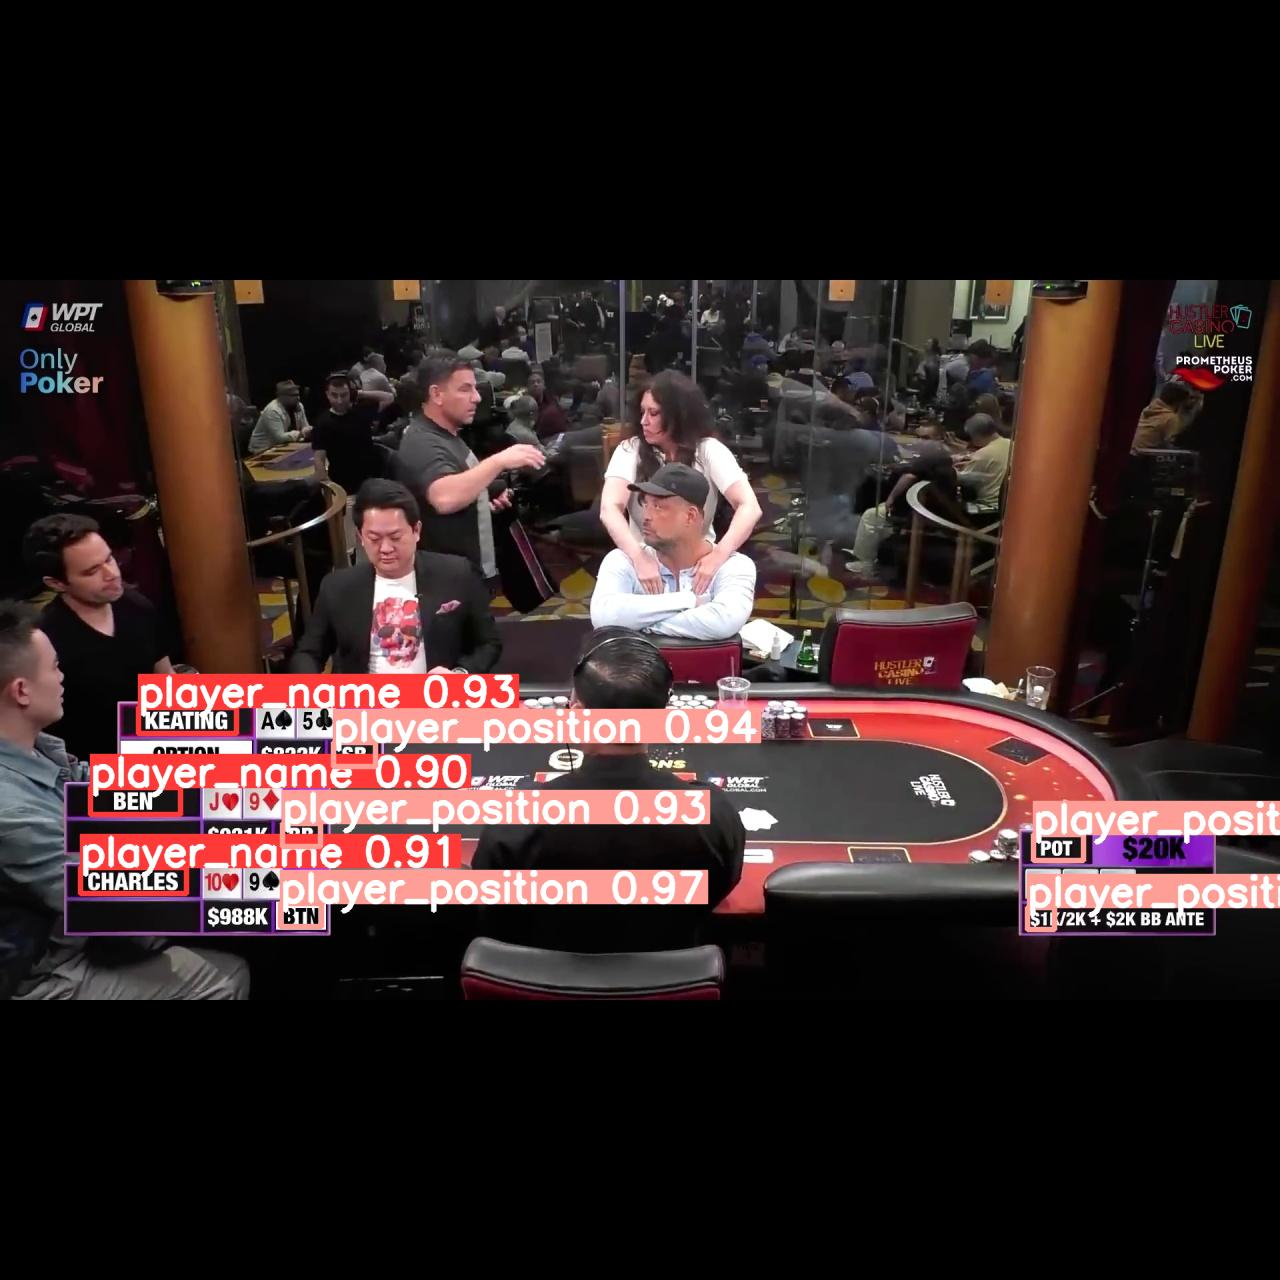

In [15]:
image_path = "/content/results.jpg"
image = read_image(image_path)
image

# **Loading the new test image from which player names and their corrosponding positions would be extracted, You can choose any test image of poker game**

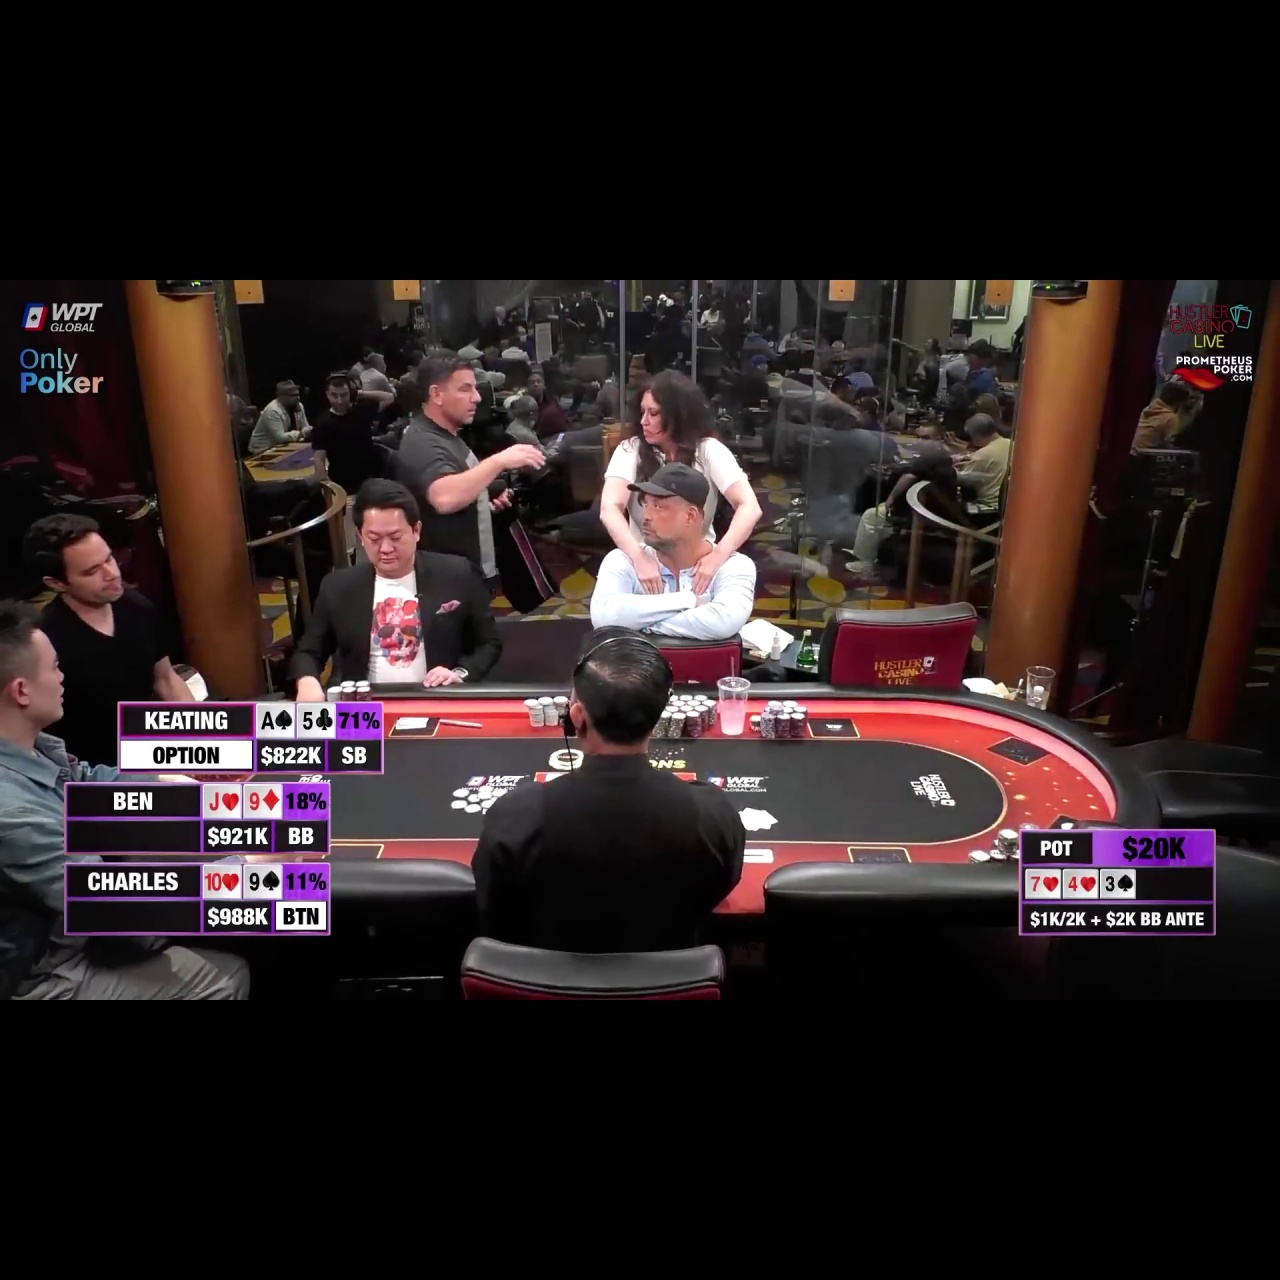

In [16]:
image_path = "/content/T_29.jpg"
image = read_image(image_path)
image

# **Loading the pretrained TrOCR model and its processor from huggingface transformers for character recogintion inference**

In [18]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-str')
model_l = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-str').to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## **Applying detection on test image using fintuned-yolov8 model**

In [20]:
frame ="/content/T_29.jpg"
result = model(frame, agnostic_nms=True)[0]
detections = sv.Detections.from_ultralytics(result)


image 1/1 /content/T_29.jpg: 640x640 3 player_names, 5 player_positions, 3544.2ms
Speed: 24.2ms preprocess, 3544.2ms inference, 332.7ms postprocess per image at shape (1, 3, 640, 640)


# **This ocr function will be utilized to extract text from the detection boxes**

In [21]:
def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model_l.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# **Main logic to mapp the Player name with their corrosponding position after extracting the text from detected text boxes. It can be easily modify to adopt with changing position of player name and it position**

In [22]:
import cv2
from PIL import Image
import os

image_path = '/content/T_29.jpg'
image = cv2.imread(image_path)

# Check if there is at least one detection
if detections.xyxy.shape[0] > 0:
    saved_images = {"player_name": [], "player_position": []}

    for i, (bbox, class_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
        # bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, bbox)

        # coordinates
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(image.shape[1], xmax)
        ymax = min(image.shape[0], ymax)

        # onlty include those detection whose confidence is greater than 0.7
        if conf > 0.7:
            # Save each cropped image with a unique filename based on class ID
            filename = f'cropped_image_class_{class_id}_box_{i}.jpg'
            saved_images["player_name" if class_id == 0 else "player_position"].append(
                {"filename": filename, "ymin": ymin}
            )
            cv2.imwrite(filename, image[ymin:ymax, xmin:xmax])

    # Sort images based on ymin
    saved_images["player_name"].sort(key=lambda x: x["ymin"])
    saved_images["player_position"].sort(key=lambda x: x["ymin"])

    # Process the saved images using TrOCR
    player_names = []
    player_positions = []

    for player_name_info, player_position_info in zip(saved_images["player_name"], saved_images["player_position"]):
        player_name_image = player_name_info["filename"]
        player_position_image = player_position_info["filename"]

        player_name_text = ocr(Image.open(player_name_image).convert('RGB'), processor, model_l)
        player_names.append(player_name_text.strip())

        player_position_text = ocr(Image.open(player_position_image).convert('RGB'), processor, model_l)
        player_positions.append(player_position_text.strip())

    player_mapping = dict(zip(player_names, player_positions))

    print("Mapped Player Names to Positions:")
    for player_name, player_position in player_mapping.items():
        print(f"{player_name}: {player_position}")

else:
    print("No detections found.")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Mapped Player Names to Positions:
KEATING: SB
BEN: BB
CHARLES: BTN
